# HM2: Numerical Optimization for Logistic Regression.

### Name: [Prajwal Prakash]


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM2/HM2.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [263]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()
print('Shape of x_sparse: ' + str(x_sparse.shape))
print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))
x

Shape of x_sparse: (768, 8)
Shape of x: (768, 8)
Shape of y: (768,)


matrix([[  6.      , 148.      ,  72.      , ...,  33.599998,   0.627   ,
          50.      ],
        [  1.      ,  85.      ,  66.      , ...,  26.6     ,   0.351   ,
          31.      ],
        [  8.      , 183.      ,  64.      , ...,  23.299999,   0.672   ,
          32.      ],
        ...,
        [  5.      , 121.      ,  72.      , ...,  26.200001,   0.245   ,
          30.      ],
        [  1.      , 126.      ,  60.      , ...,  30.1     ,   0.349   ,
          47.      ],
        [  1.      ,  93.      ,  70.      , ...,  30.4     ,   0.315   ,
          23.      ]])

## 1.2. Partition to training and test sets

In [264]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [265]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.07309402 -0.06438543 -0.00810089  0.07787645  0.03726519 -0.02112581
   0.00858525  0.01227663]]
test std = 
[[1.01778317 0.91243307 1.07557617 1.00167133 1.09089355 1.22714257
  1.10406648 1.08533063]]


## 1.4. Add a dimension of all ones

In [266]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [267]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [268]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [269]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [270]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [271]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5883837482593802
Objective value at t=2 is 0.5457764961504971
Objective value at t=3 is 0.5228740529859363
Objective value at t=4 is 0.5085761039245927
Objective value at t=5 is 0.49888906580827
Objective value at t=6 is 0.49198941141061964
Objective value at t=7 is 0.4869064333424738
Objective value at t=8 is 0.483068461190786
Objective value at t=9 is 0.480114847241961
Objective value at t=10 is 0.47780668078608846
Objective value at t=11 is 0.4759798360251908
Objective value at t=12 is 0.4745183226979188
Objective value at t=13 is 0.47333826388512296
Objective value at t=14 is 0.4723778280747463
Objective value at t=15 is 0.47159067876647687
Objective value at t=16 is 0.47094159058248813
Objective value at t=17 is 0.4704034452151521
Objective value at t=18 is 0.46995513076731876
Objective value at t=19 is 0.46958004650382823
Objective value at t=20 is 0.46926502158845007
Objective value at t=21 is 0.46899952199

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [272]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [273]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [274]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5314463961498068
Objective value at epoch t=1 is 0.512003145327204
Objective value at epoch t=2 is 0.5127685994823221
Objective value at epoch t=3 is 0.49936900061089784
Objective value at epoch t=4 is 0.4971955003237076
Objective value at epoch t=5 is 0.493406396449373
Objective value at epoch t=6 is 0.4958236112332136
Objective value at epoch t=7 is 0.48840392542029887
Objective value at epoch t=8 is 0.491253012744863
Objective value at epoch t=9 is 0.4865538564348693
Objective value at epoch t=10 is 0.4884177581768867
Objective value at epoch t=11 is 0.4828032818214435
Objective value at epoch t=12 is 0.48412102213478453
Objective value at epoch t=13 is 0.4813692291778155
Objective value at epoch t=14 is 0.48120547269013203
Objective value at epoch t=15 is 0.47995617803883517
Objective value at epoch t=16 is 0.4777770905319384
Objective value at epoch t=17 is 0.4773331275670216
Objective value at epoch t=18 is 0.4767131176069343
Objective value at e

# 4. Compare GD with SGD

Plot objective function values against epochs.

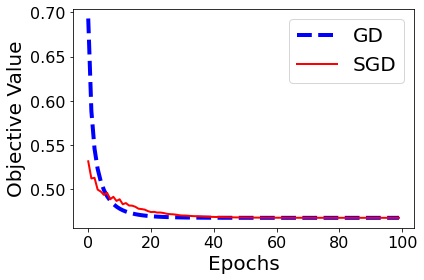

In [275]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [276]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [277]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2171875


In [278]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.234375


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [279]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications
    yx = numpy.multiply(xi,yi) # b-by-d matrix
    yxw = numpy.dot(yx, w) # b-by-1 matrix
    
    # calculate objective function Q_i
    loss = numpy.mean(numpy.log(1 + numpy.exp(-yxw)))  # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    gradient_loss = -numpy.mean(numpy.divide(yx, 1 + numpy.exp(yxw)), axis=0).reshape(d, 1) # d-by-1 matrix
    g = gradient_loss + lam * w # d-by-1 matrix
    
    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [280]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
  # Fill the function
  # Follow the implementation of sgd
  # Record one objective value per epoch (not per iteration!)
  n, d = x.shape
  objvals = numpy.zeros(max_epoch) # store the objective values
  if w is None:
    w = numpy.zeros((d, 1)) # zero initialization
  for t in range(max_epoch):
    rand_indices = numpy.random.permutation(n)
    value = 0
    rang = n // b
    for i in range(0, rang, 1):
      rowstart = i*b
      rowend = rowstart+b
      train_Minibatch = x[rand_indices[rowstart:rowend], :]
      test_Minibatch = y[rand_indices[rowstart:rowend], :] 
      obj, g = mb_stochastic_objective_gradient(w, train_Minibatch, test_Minibatch, lam, b)
      value = value + obj
      w -= stepsize*g
    stepsize *= 0.9 # decrease step size
    temp = b/n
    value *= temp
    objvals[t]=value
    print('Objective value at epoch t=' + str(t) + ' is ' + str(value))
  
  return w, objvals

## 6.3. Run MB-SGD

In [281]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.58 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5220330558901626
Objective value at epoch t=1 is 0.5031461992675069
Objective value at epoch t=2 is 0.49864119240711846
Objective value at epoch t=3 is 0.49440124102724364
Objective value at epoch t=4 is 0.4841648921505475
Objective value at epoch t=5 is 0.4888252682688706
Objective value at epoch t=6 is 0.48627516905923873
Objective value at epoch t=7 is 0.48405138167331646
Objective value at epoch t=8 is 0.486965115910685
Objective value at epoch t=9 is 0.4790737493223769
Objective value at epoch t=10 is 0.47939026461608675
Objective value at epoch t=11 is 0.47954061274410775
Objective value at epoch t=12 is 0.4796128338049177
Objective value at epoch t=13 is 0.47693773569614734
Objective value at epoch t=14 is 0.47822762121009793
Objective value at epoch t=15 is 0.4753737584840943
Objective value at epoch t=16 is 0.47482660287292755
Objective value at epoch t=17 is 0.4744041970242651
Objective value at epoch t=18 is 0.4745488350323447
Objective valu

In [282]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.48 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5747056317946146
Objective value at epoch t=1 is 0.4980117324866609
Objective value at epoch t=2 is 0.48277735628731444
Objective value at epoch t=3 is 0.4749692932946407
Objective value at epoch t=4 is 0.4733481338398444
Objective value at epoch t=5 is 0.4724553308100126
Objective value at epoch t=6 is 0.4710596802602314
Objective value at epoch t=7 is 0.47032004325573595
Objective value at epoch t=8 is 0.4699793354554276
Objective value at epoch t=9 is 0.46957333884537883
Objective value at epoch t=10 is 0.469403987090041
Objective value at epoch t=11 is 0.46881160079782824
Objective value at epoch t=12 is 0.4692045625683992
Objective value at epoch t=13 is 0.46894603849578387
Objective value at epoch t=14 is 0.46861900693521685
Objective value at epoch t=15 is 0.4687616027415336
Objective value at epoch t=16 is 0.46839316463439656
Objective value at epoch t=17 is 0.46821557962389404
Objective value at epoch t=18 is 0.46818607825818576
Objective valu

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

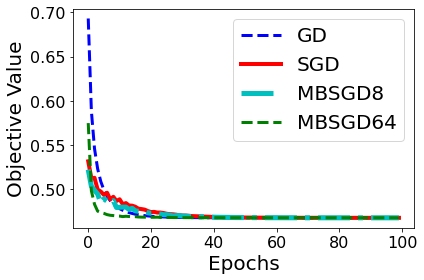

In [283]:
# plot the 4 curves:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=3)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=4)
line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '-.c', LineWidth=5)
line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '--g', LineWidth=3)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD','MBSGD8', 'MBSGD64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)